# Dataset và DataLoaders

Pytorch có 2 module là `torch.utils.data.Dataset` và `torch.utils.data.DataLoader`.

Trong đó:
- `Dataset` để store data
- `DataLoader` để bọc một cái `iterable` quanh `Dataset` để giúp truy cập đến các samples.

Pytorch cung cấp nhiều datasets như `FashionMNIST`, bộ datasets này có subclass là `torch.utils.Dataset`.

Đọc thêm về : `Image Datasets, Text Datasets, Audio Datasets` [tại đây](https://pytorch.org/vision/stable/datasets.html)


## 1. Loading a Dataset

Ví dụ với việc load [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) từ TorchVision. Bộ datasets này là của Zalando's article images gồm có 60,000 training examples và 10,000 test examples. Mỗi example lại có ảnh xám size 28x28 được gán bởi 1 trong 10 nhãn.

Thông thường load data bằng `torchvision.datasets` sẽ có cấu trúc như sau (Ví dụ với FashionMNIST):

- `root` là đường dẫn đến nơi mà data sẽ được lưu trữ trong project
- `train` chỉ định dataset được load là train hay test
- `download=True` downloads data từ internet về nếu nó không có sẵn trong `root`
- `transform` và `target_transform` là chỉ định cho việc transform các input hoặc nhãn tương ứng.

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Load train data
training_data = datasets.FashionMNIST(
    root="../../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../../data",
    train=False,
    download=True,
    transform=ToTensor()
)





Nếu như chưa download về root thì data sẽ được download và có output như sau:

```cmd
Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to data/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw

Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw

Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
```

### Visualize data

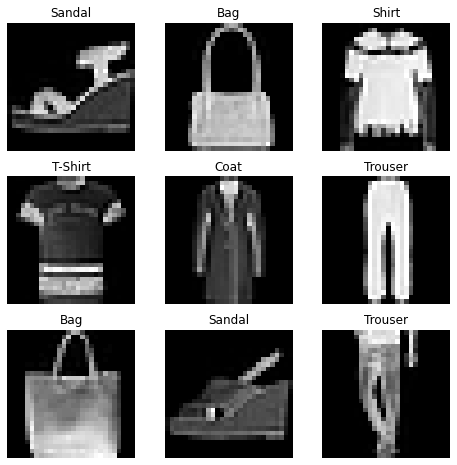

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Custom dataset

Để custom Dataset thì class Dataset mới phải kế thừa `torch.utils.data.Dataset` và class này phải implement lại 3 functions: `__init__`, `__len__`, `__getitem__`.

In [6]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

# gradient computation etc. not efficient for whole data set
# -> divide dataset into small batches

'''
# training loop
for epoch in range(num_epochs):
    # loop over all batches
    for i in range(total_batches):
        batch_x, batch_y = ...
'''

# epoch = one forward and backward pass of ALL training samples
# batch_size = number of training samples used in one forward/backward pass
# number of iterations = number of passes, each pass (forward+backward) using [batch_size] number of sampes
# e.g : 100 samples, batch_size=20 -> 100/20=5 iterations for 1 epoch

# --> DataLoader can do the batch computation for us

# Implement a custom Dataset:
# inherit Dataset
# implement __init__ , __getitem__ , and __len__

class WineDataset(Dataset):

    def __init__(self):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt('../../data/wine/wine.csv', delimiter=',', dtype=np.float32, skiprows=1)
        self.n_samples = xy.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(xy[:, 1:]) # size [n_samples, n_features]
        print("OK",self.x_data.shape)
        self.y_data = torch.from_numpy(xy[:, [0]]) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


# create dataset
dataset = WineDataset()

# get first sample and unpack
first_data = dataset[0]
features, labels = first_data
print(features, labels)

# Load whole dataset with DataLoader
# shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses
# !!! IF YOU GET AN ERROR DURING LOADING, SET num_workers TO 0 !!!
train_loader = DataLoader(dataset=dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=0)

# convert to an iterator and look at one random sample
dataiter = iter(train_loader)
data = dataiter.next()
features, labels = data
print(features, labels)

# Dummy Training loop
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        
        # here: 178 samples, batch_size = 4, n_iters=178/4=44.5 -> 45 iterations
        # Run your training process
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| Inputs {inputs.shape} | Labels {labels.shape}')

# some famous datasets are available in torchvision.datasets
# e.g. MNIST, Fashion-MNIST, CIFAR10, COCO

train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),  
                                           download=True)

train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=3, 
                                           shuffle=True)

# look at one random sample
dataiter = iter(train_loader)
data = dataiter.next()
inputs, targets = data
print(inputs.shape, targets.shape)

OK torch.Size([178, 13])
tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) tensor([1.])
tensor([[1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
         3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
         1.0650e+03],
        [1.2700e+01, 3.8700e+00, 2.4000e+00, 2.3000e+01, 1.0100e+02, 2.8300e+00,
         2.5500e+00, 4.3000e-01, 1.9500e+00, 2.5700e+00, 1.1900e+00, 3.1300e+00,
         4.6300e+02],
        [1.1560e+01, 2.0500e+00, 3.2300e+00, 2.8500e+01, 1.1900e+02, 3.1800e+00,
         5.0800e+00, 4.7000e-01, 1.8700e+00, 6.0000e+00, 9.3000e-01, 3.6900e+00,
         4.6500e+02],
        [1.3830e+01, 1.5700e+00, 2.6200e+00, 2.0000e+01, 1.1500e+02, 2.9500e+00,
         3.4000e+00, 4.0000e-01, 1.7200e+00, 6.6000e+00, 1.1300e+00, 2.5700e+00,
         1.1300e+03]]) tensor([[1.],
        [2.],
        [2.],
  